## Simple Reinforcemet Learning with TensorFlow
Notebooks to accompany tutorials by @awjuliani

### Part-0: Q-learning with tables and neural networks

This tutorial will use the _Frozen Lake_ environment from the OpenAI gym. In the _Frozen Lake_ there is a discrete _observation space_ with 16 states, each corresponding to the position on a 4x4 grid. There is a disctete _action space_ corresponding to movement in the four cardinal directions.

### Q-table learning

In [15]:
import gym
from gym import wrappers
from numpy import zeros, max, argmax
from numpy.random import randn

# Create environment
env = gym.make('FrozenLake-v0')

# Set seed
env.seed(0)

# Set directory for results
env = wrappers.Monitor(env, './results/Q-table-experiment-1', force=True)

# Initialize an empty Q table
Q = zeros([env.observation_space.n, env.action_space.n])

# Set learning parameters
learning = 0.85
discount = 0.99
episodes = 2000

for i in range(episodes):
    #Reset environment and get first new observation
    observation = env.reset()
    done = False
    j = 0
    #The Q-Table learning algorithm
    while j < 500:
        j+=1
        #Choose an action by greedily (with noise) picking from Q table
        action = argmax(Q[observation, :] + randn(1,env.action_space.n)*(1./(i+1)))
        #Get new state and reward from environment
        observation1, reward, done, info = env.step(action)
        #Update Q-Table with new knowledge
        Q[observation, action] += learning*(reward + discount*max(Q[observation1, :]) - Q[observation, action])
        observation = observation1
        if done == True:
            break
env.close()    

[2017-03-20 19:52:45,807] Making new env: FrozenLake-v0
[2017-03-20 19:52:45,826] Clearing 24 monitor files from previous run (because force=True was provided)
[2017-03-20 19:52:45,831] Starting new video recorder writing to /Users/sofroniewn/Github/sRLwTF/part-0/results/Q-table-experiment-1/openaigym.video.1.3538.video000000.json
[2017-03-20 19:52:45,835] Starting new video recorder writing to /Users/sofroniewn/Github/sRLwTF/part-0/results/Q-table-experiment-1/openaigym.video.1.3538.video000001.json
[2017-03-20 19:52:45,852] Starting new video recorder writing to /Users/sofroniewn/Github/sRLwTF/part-0/results/Q-table-experiment-1/openaigym.video.1.3538.video000008.json
[2017-03-20 19:52:45,872] Starting new video recorder writing to /Users/sofroniewn/Github/sRLwTF/part-0/results/Q-table-experiment-1/openaigym.video.1.3538.video000027.json
[2017-03-20 19:52:45,904] Starting new video recorder writing to /Users/sofroniewn/Github/sRLwTF/part-0/results/Q-table-experiment-1/openaigym.video

## Evaluate Results

In [48]:
directory = './results/Q-table-experiment-1'

from gym.monitoring import load_results
from gym.scoreboard.scoring import score_from_local
results = load_results(directory)
score = score_from_local(directory)
score

{'episode_t_value': None,
 'error': 0.055377492419453826,
 'mean': 0.54000000000000004,
 'number_episodes': 2000,
 'number_timesteps': 110691,
 'seconds_in_total': 3.4773201942443848,
 'seconds_to_solve': None,
 'timestep_t_value': None}

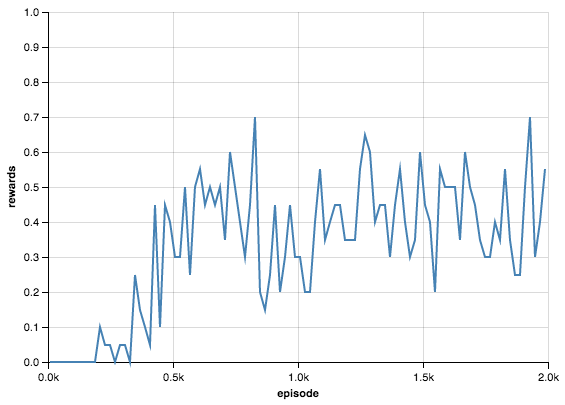

In [49]:
from gym.scoreboard.scoring import compute_graph_stats
CURR_EPISODE = 100
graphs = compute_graph_stats(results['episode_lengths'], results['episode_rewards'], results['timestamps'], results['initial_reset_timestamp'], CURR_EPISODE)

from pandas import DataFrame
data = DataFrame({'episode': graphs['x_episode_y_reward']['x'],
                  'rewards': graphs['x_episode_y_reward']['y']})

from altair import Chart, Y, Scale

chart = Chart(data).mark_line().encode(
    x='episode',
    y='rewards'
)
chart.encode(Y('rewards', scale=Scale(domain=[0, 1])))

### Q-learning with Neural Networks

Now we will use a neural network as a function approximator to approximate Q. The network takes a one-hot vector (1x16) and produces a vector of 4 Q values, one for each action.

In [8]:
import gym
from gym import wrappers
from numpy import zeros, max, argmax
from numpy.random import randn

# Create environment
env = gym.make('FrozenLake-v0')

# Set seed
env.seed(0)

# Set directory for results
env = wrappers.Monitor(env, './results/Q-network-experiment-2', force=True)

[2017-03-21 22:27:12,681] Making new env: FrozenLake-v0
[2017-03-21 22:27:12,695] Clearing 24 monitor files from previous run (because force=True was provided)


### Implement the network

In [9]:
import tensorflow as tf
tf.reset_default_graph()

#These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,env.observation_space.n],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([env.observation_space.n, env.action_space.n],0,0.01))
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,env.action_space.n],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

### Train the network

In [10]:
from numpy import identity, max
from numpy.random import rand

init = tf.global_variables_initializer()

# Set learning parameters
discount = 0.99
error = 0.1
episodes = 2000

with tf.Session() as sess:
    sess.run(init)
    for i in range(episodes):
        #Reset environment and get first new observation
        observation = env.reset()
        done = False
        j = 0
        #The Q-Network
        while j < 500:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            action, allQ = sess.run([predict, Qout], feed_dict={inputs1:identity(env.observation_space.n)[observation:observation+1]})
            if rand(1) < error:
                action[0] = env.action_space.sample()
            #Get new state and reward from environment
            observation1, reward, done, info = env.step(action[0])
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout, feed_dict={inputs1:identity(env.observation_space.n)[observation1:observation1+1]})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = max(Q1)
            targetQ = allQ
            targetQ[0, action[0]] = reward + discount*maxQ1
            #Train our network using target and predicted Q values
            _, W1 = sess.run([updateModel,W], feed_dict={inputs1:identity(env.observation_space.n)[observation:observation+1], nextQ:targetQ})
            observation = observation1
            if done == True:
                #Reduce chance of random action as we train the model.
                error = 1./((i/50) + 10)
                break
env.close()

[2017-03-21 22:27:14,703] Starting new video recorder writing to /Users/sofroniewn/Github/sRLwTF/part-0/results/Q-network-experiment-2/openaigym.video.1.11367.video000000.json
[2017-03-21 22:27:14,720] Starting new video recorder writing to /Users/sofroniewn/Github/sRLwTF/part-0/results/Q-network-experiment-2/openaigym.video.1.11367.video000001.json
[2017-03-21 22:27:14,780] Starting new video recorder writing to /Users/sofroniewn/Github/sRLwTF/part-0/results/Q-network-experiment-2/openaigym.video.1.11367.video000008.json
[2017-03-21 22:27:14,895] Starting new video recorder writing to /Users/sofroniewn/Github/sRLwTF/part-0/results/Q-network-experiment-2/openaigym.video.1.11367.video000027.json
[2017-03-21 22:27:15,072] Starting new video recorder writing to /Users/sofroniewn/Github/sRLwTF/part-0/results/Q-network-experiment-2/openaigym.video.1.11367.video000064.json
[2017-03-21 22:27:15,430] Starting new video recorder writing to /Users/sofroniewn/Github/sRLwTF/part-0/results/Q-networ

## Evaluate results

In [11]:
directory = './results/Q-network-experiment-2'

from gym.monitoring import load_results
from gym.scoreboard.scoring import score_from_local
results = load_results(directory)
score = score_from_local(directory)
score

{'episode_t_value': None,
 'error': 0.039674602380793608,
 'mean': 0.14999999999999999,
 'number_episodes': 2000,
 'number_timesteps': 20494,
 'seconds_in_total': 18.54342794418335,
 'seconds_to_solve': None,
 'timestep_t_value': None}

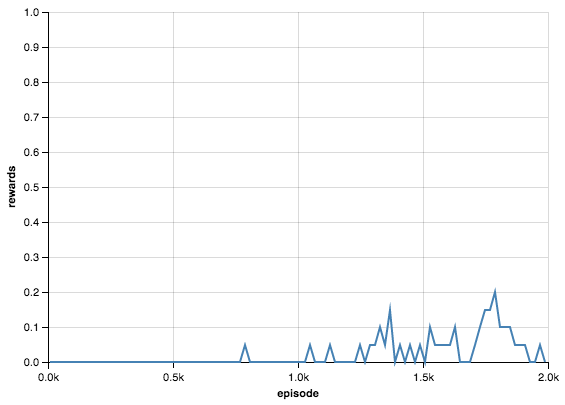

In [12]:
from gym.scoreboard.scoring import compute_graph_stats
CURR_EPISODE = 100
graphs = compute_graph_stats(results['episode_lengths'], results['episode_rewards'], results['timestamps'], results['initial_reset_timestamp'], CURR_EPISODE)

from pandas import DataFrame
data = DataFrame({'episode': graphs['x_episode_y_reward']['x'],
                  'rewards': graphs['x_episode_y_reward']['y']})

from altair import Chart, Y, Scale

chart = Chart(data).mark_line().encode(
    x='episode',
    y='rewards'
)
chart.encode(Y('rewards', scale=Scale(domain=[0, 1])))